# Quickstart

In this tutorial we show how to obtain a mock-catalogue using `scampy`.

First, we will load a DM halo/sub-halo hierarchy obtained with the SUBFIND algorithm applied on a $z = 0$ GADGET snapshot.
Then, we will 
1. populate the catalogue with galaxies
2. associate to each galaxy a luminosity

First of all, we populate the namespaces from numpy and matplotlib (it would be enough to state `import numpy as np` for working, this is mostly useful for plotting)

In [1]:
# import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Now, we import the `catalogue` module from `scampy`:

In [2]:
from scampy import catalogue

We now build an object of type catalogue and read the halo/sub-halo hierarchy from the binary output of the SUBFIND algorithm.

**Note** that, tipically, these outputs are given as a set of files with a common base-name, e.g. `subhalo_tab.0` for the first file in the set. Here we just need to provide the common name of all the files, i.e. `subhalo_tab`.

In [3]:
cat = catalogue.catalogue()
cat.read_hierarchy_from_gadget( "input/subhalo_tab" )

The catalogue we provide in the `input` directory has been obtained for a simulation box with side-lenght $L_\text{box} = 512\ \text{Mpc}/h$, thus we can define a `volume` variable that we will use later:

In [4]:
volume = 512**3

## 1. Populate catalogue

We will now populate the above catalogue with a 4-parameters HOD model:
\begin{align}
N_\text{cen} =& \dfrac{1}{2} \biggl[1 + \text{erf}\biggl(\dfrac{\log M_h - \log A_\text{min}}{\sigma_{\log A}}\biggr)\biggr]\\
N_\text{sat} =& \biggl(\dfrac{M_h}{A_\text{sat}}\biggr)^\alpha_\text{sat}
\end{align}
with parameters: $A_\text{min} = 10^{14}\ M_\odot/h$, $\sigma_{\log A} = 0.5$, $A_\text{sat} = 10^{15}\ M_\odot/h$ and $\alpha_\text{sat} = 1$.

To do so, we have first to build an object of type `occupation_p` with given parameters:

In [5]:
from scampy import occupation_p
ocp = occupation_p.tinker10_p( Amin = 1.e+14, siglogA = 0.5, Asat=1.e+15, alpsat=1. )

Then, we can call the `populate` function of the class catalogue, which returns a populated catalogue and the number of hosted galaxies:

In [6]:
gxy_cat, Ng = cat.populate( ocp )

## 2. Associate luminosity

In order to run the SHAM algorithm, we import the `abundance_matching` module of `scampy`

In [7]:
from scampy import abundance_matching

First of all, we need the probability distribution of the observable we want to add to the mock galaxies.

Le us define a Schechter luminosity function:
\begin{equation}
\phi( M ) = 0.4 \ln(10) \phi^* 10^{0.4 (\alpha + 1) (M - M^* )} \exp\bigl( -10^{0.4 (M - M^* )}\bigr)
\end{equation}

In [8]:
def schechter ( mag ) :
    alpha = -1.07
    norm = 1.6e-2
    mstar = -19.7 + 5. * np.log10( 5. )
    lum = - 0.4 * ( mag - mstar )
    return 0.4 * np.log( 10 ) * norm * 10**( - 0.07 * lum ) * np.exp( - 10**lum )

The routine that implements the SHAM algorithm operates on arrays of `galaxy` type objects, instead of on objects of type `catalogue`.

Such arrays can be extracted from a populated catalogue either directly, by calling the `populate()` function with the argument `extract = True`:
```python
galaxies = cat.populate( ocp, extract = True )
```
or by calling the `extract_galaxies()` function of the `catalogue` module.
This function takes 2 arguments:
- an array of `host_halo` type objects (i.e. the `content` of a catalogue;
- the number of galaxies found by the `populate` algorithm.

In [9]:
galaxies = catalogue.extract_galaxies( gxy_cat.content, Ng )

At this point we have everything we need for running the SHAM algorithm.
It is implemented in the `abundance_matching()` function of the `abundance_matching` module.
This function takes several argumens, we refer the reader to the documentation for a detailed description.

The positional arguments are:
- the array of `galaxy` type objects (`galaxies`);
- the probability distribution of the observable property we want to match (it must depend only on one-variable).
Here we are also setting the following keyword arguments:
- `minL` and `maxL`, the limits of the free-variable in our probability distribution;
- `nbinM`, the number of bins we want to divide the mass-space;
- `factM`, the constant factor to multiply the mass-distribution (since we want a volume density, here we are passing `1/volume`.

In [10]:
galaxies = abundance_matching.abundance_matching( galaxies, schechter, 
                                                  minL = -20, maxL = -10,
                                                  nbinM = 20, factM = 1. / volume ) 

/opt/miniconda3/envs/learn/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  


... and that's all folks!

The `galaxies` array now contains all the mock-galaxies of our catalogue.

## Analysis

In [11]:
luminosities = np.array( [ gxy.luminosity for gxy in galaxies ] )
mag_mes = linspace( np.min( luminosities ), np.max( luminosities ), 10 )
phi_mes, phi_mes_er = abundance_matching.cumulative_counts( -1 * luminosities, -1 * mag_mes, 1. / volume )

/opt/miniconda3/envs/learn/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  


<ErrorbarContainer object of 3 artists>

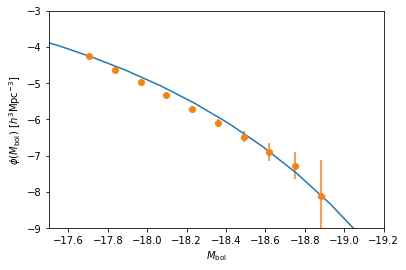

In [12]:
plt.xlabel( '$M_\mathrm{bol}$' )
plt.ylabel( '$\phi( M_\mathrm{bol} )\ [h^3 \mathrm{Mpc}^{-3}]$' )

plt.xlim( [ -17.5, -19.2 ] )
plt.ylim( [ -9, -3 ] )

size = 30
MM = linspace( -21, -16., size )

plot( MM, np.log10( abundance_matching.cumulative_from_differential( schechter, MM, 1. ) ) )
# plot( mag_mes, np.log10( phi_mes ) )
errorbar( mag_mes, np.log10( phi_mes ), 
          yerr = phi_mes_er / phi_mes, fmt = 'o' )